In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torchvision.datasets.folder import default_loader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

In [4]:
batch_size = 100
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
workers=3
dataroot = r"C:\Users\kilbo\Documents\GitHub\dsci478k\data"

In [5]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
                                   #                                    transforms.RandomCrop(32, padding=2),
                                   #                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root=dataroot,
                                            transform=transform_ds)
device = torch.device("cuda")
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

7338


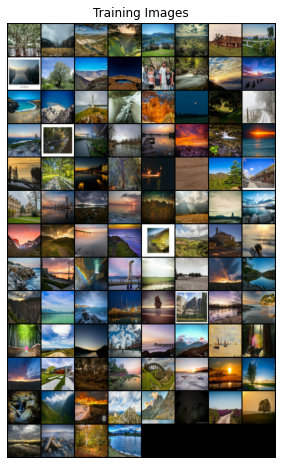

In [6]:
real_batch = next(iter(train_dl))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:100], padding=2, normalize=True).cpu(),(1,2,0)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


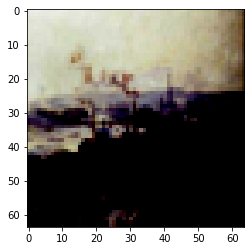

In [7]:
images,label = train_ds[299]

print(images.size())
plt.imshow(np.transpose(images, (1, 2, 0)))


In [9]:

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
train_dl = DeviceDataLoader(train_dl,device)

In [11]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [12]:
discriminator = to_device(discriminator,device)

In [13]:
latent_size=150

In [14]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [15]:
xb = torch.rand(batch_size,latent_size,1,1)

torch.Size([100, 3, 64, 64])


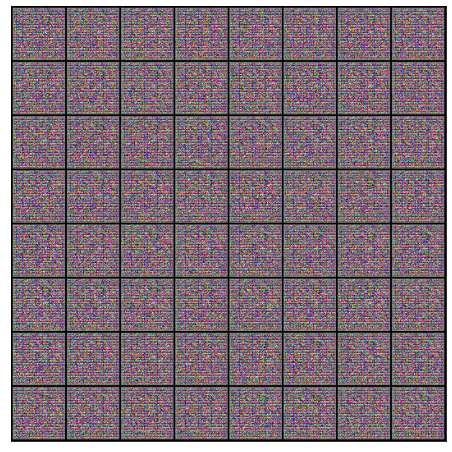

In [16]:
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

#[batchsize,rgb,w,h]

In [17]:
generator = to_device(generator, device)

In [18]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [19]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [20]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [21]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [22]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


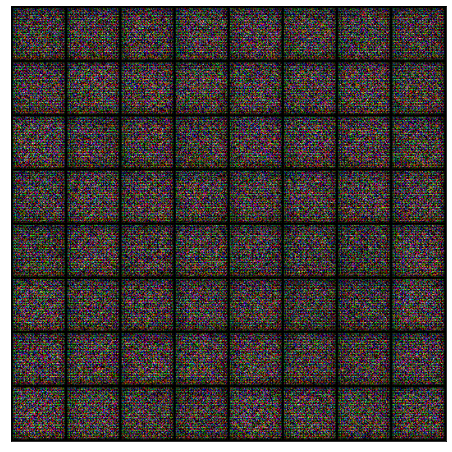

In [23]:
save_samples(0, fixed_latent)

In [24]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [25]:
lr = 0.001
epochs = 150

In [26]:
history = fit(epochs,lr)

  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 2.5761, loss_d: 1.5833, real_score: 0.3074, fake_score: 0.0081
Saving generated-images-0001.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 1.4694, loss_d: 1.1737, real_score: 0.7537, fake_score: 0.5505
Saving generated-images-0002.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 2.1615, loss_d: 1.1761, real_score: 0.8289, fake_score: 0.5675
Saving generated-images-0003.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 1.7537, loss_d: 0.7182, real_score: 0.6172, fake_score: 0.1704
Saving generated-images-0004.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 1.4173, loss_d: 1.1247, real_score: 0.4680, fake_score: 0.2407
Saving generated-images-0005.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 4.0702, loss_d: 1.7163, real_score: 0.7639, fake_score: 0.6784
Saving generated-images-0006.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 1.0105, loss_d: 1.1303, real_score: 0.5042, fake_score: 0.3064
Saving generated-images-0007.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 1.4504, loss_d: 1.1918, real_score: 0.5114, fake_score: 0.3200
Saving generated-images-0008.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 2.6055, loss_d: 1.0943, real_score: 0.7237, fake_score: 0.4978
Saving generated-images-0009.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 3.6378, loss_d: 1.1136, real_score: 0.6781, fake_score: 0.4703
Saving generated-images-0010.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 2.4647, loss_d: 0.8678, real_score: 0.6672, fake_score: 0.3141
Saving generated-images-0011.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 3.1710, loss_d: 0.7857, real_score: 0.7622, fake_score: 0.3669
Saving generated-images-0012.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 1.5316, loss_d: 0.9874, real_score: 0.5170, fake_score: 0.2061
Saving generated-images-0013.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 2.2172, loss_d: 0.8621, real_score: 0.6529, fake_score: 0.3011
Saving generated-images-0014.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 1.6964, loss_d: 1.1088, real_score: 0.4236, fake_score: 0.0926
Saving generated-images-0015.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 1.8824, loss_d: 1.2714, real_score: 0.4163, fake_score: 0.1891
Saving generated-images-0016.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 3.7414, loss_d: 0.8450, real_score: 0.7820, fake_score: 0.3938
Saving generated-images-0017.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 3.8599, loss_d: 0.9286, real_score: 0.7656, fake_score: 0.4168
Saving generated-images-0018.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 1.9556, loss_d: 0.8022, real_score: 0.6473, fake_score: 0.2518
Saving generated-images-0019.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 2.7583, loss_d: 0.8048, real_score: 0.6000, fake_score: 0.1330
Saving generated-images-0020.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 3.2126, loss_d: 0.8616, real_score: 0.8176, fake_score: 0.4079
Saving generated-images-0021.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 4.2205, loss_d: 1.8404, real_score: 0.8677, fake_score: 0.7549
Saving generated-images-0022.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 5.3776, loss_d: 1.0126, real_score: 0.8374, fake_score: 0.5065
Saving generated-images-0023.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 4.4674, loss_d: 1.4548, real_score: 0.9217, fake_score: 0.6850
Saving generated-images-0024.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 1.3887, loss_d: 0.9555, real_score: 0.5147, fake_score: 0.1724
Saving generated-images-0025.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 3.4980, loss_d: 0.9565, real_score: 0.8322, fake_score: 0.4838
Saving generated-images-0026.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 1.1215, loss_d: 1.1308, real_score: 0.5237, fake_score: 0.2936
Saving generated-images-0027.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 4.2504, loss_d: 1.3305, real_score: 0.8520, fake_score: 0.6306
Saving generated-images-0028.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 1.3404, loss_d: 1.1944, real_score: 0.4514, fake_score: 0.1561
Saving generated-images-0029.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 4.6998, loss_d: 0.9823, real_score: 0.8056, fake_score: 0.4652
Saving generated-images-0030.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 5.1319, loss_d: 0.6541, real_score: 0.9475, fake_score: 0.4124
Saving generated-images-0031.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 0.8161, loss_d: 1.2095, real_score: 0.3970, fake_score: 0.0992
Saving generated-images-0032.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 2.5608, loss_d: 0.5909, real_score: 0.6913, fake_score: 0.1226
Saving generated-images-0033.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 3.2939, loss_d: 0.7438, real_score: 0.8901, fake_score: 0.4111
Saving generated-images-0034.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 0.7874, loss_d: 1.8686, real_score: 0.2508, fake_score: 0.0261
Saving generated-images-0035.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 3.5944, loss_d: 1.2821, real_score: 0.8182, fake_score: 0.5867
Saving generated-images-0036.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 2.9076, loss_d: 0.5051, real_score: 0.9446, fake_score: 0.3242
Saving generated-images-0037.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 1.1919, loss_d: 0.8693, real_score: 0.5659, fake_score: 0.1573
Saving generated-images-0038.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 3.2093, loss_d: 0.6490, real_score: 0.8482, fake_score: 0.3187
Saving generated-images-0039.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 1.6698, loss_d: 0.8727, real_score: 0.5571, fake_score: 0.1669
Saving generated-images-0040.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 3.2328, loss_d: 0.3932, real_score: 0.9251, fake_score: 0.2463
Saving generated-images-0041.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 0.6347, loss_d: 1.8575, real_score: 0.2533, fake_score: 0.0483
Saving generated-images-0042.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 3.7046, loss_d: 0.8533, real_score: 0.8337, fake_score: 0.4331
Saving generated-images-0043.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 3.1346, loss_d: 0.6952, real_score: 0.8455, fake_score: 0.3524
Saving generated-images-0044.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 4.8267, loss_d: 0.9985, real_score: 0.8605, fake_score: 0.4971
Saving generated-images-0045.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 4.9730, loss_d: 1.2558, real_score: 0.9385, fake_score: 0.6231
Saving generated-images-0046.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 1.9463, loss_d: 0.5553, real_score: 0.8113, fake_score: 0.2424
Saving generated-images-0047.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 2.9183, loss_d: 0.5838, real_score: 0.6640, fake_score: 0.0874
Saving generated-images-0048.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 3.4960, loss_d: 0.3933, real_score: 0.7517, fake_score: 0.0645
Saving generated-images-0049.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 2.9711, loss_d: 0.3939, real_score: 0.7830, fake_score: 0.0999
Saving generated-images-0050.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 4.4067, loss_d: 0.7342, real_score: 0.8978, fake_score: 0.3881
Saving generated-images-0051.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 4.9999, loss_d: 1.1720, real_score: 0.9649, fake_score: 0.5955
Saving generated-images-0052.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 2.9087, loss_d: 0.4672, real_score: 0.8051, fake_score: 0.1736
Saving generated-images-0053.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 5.3201, loss_d: 1.7162, real_score: 0.9913, fake_score: 0.7107
Saving generated-images-0054.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 3.8317, loss_d: 0.5108, real_score: 0.9161, fake_score: 0.2946
Saving generated-images-0055.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 3.1456, loss_d: 0.4353, real_score: 0.9355, fake_score: 0.2584
Saving generated-images-0056.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 5.8851, loss_d: 1.3777, real_score: 0.9640, fake_score: 0.6445
Saving generated-images-0057.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 1.9905, loss_d: 0.5415, real_score: 0.7005, fake_score: 0.0839
Saving generated-images-0058.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 3.9916, loss_d: 0.4518, real_score: 0.8330, fake_score: 0.1871
Saving generated-images-0059.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 3.5097, loss_d: 0.4429, real_score: 0.9187, fake_score: 0.2325
Saving generated-images-0060.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 4.4169, loss_d: 0.2668, real_score: 0.9221, fake_score: 0.1490
Saving generated-images-0061.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 4.9894, loss_d: 0.6855, real_score: 0.9602, fake_score: 0.3797
Saving generated-images-0062.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 3.5342, loss_d: 0.1949, real_score: 0.9202, fake_score: 0.0867
Saving generated-images-0063.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 5.1930, loss_d: 1.0676, real_score: 0.9712, fake_score: 0.5238
Saving generated-images-0064.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 3.6140, loss_d: 0.9533, real_score: 0.8438, fake_score: 0.3972
Saving generated-images-0065.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 1.8798, loss_d: 0.3458, real_score: 0.7959, fake_score: 0.0799
Saving generated-images-0066.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 3.7329, loss_d: 0.2160, real_score: 0.8621, fake_score: 0.0510
Saving generated-images-0067.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 5.1215, loss_d: 0.4676, real_score: 0.9848, fake_score: 0.2914
Saving generated-images-0068.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 2.9468, loss_d: 1.2113, real_score: 0.6945, fake_score: 0.3924
Saving generated-images-0069.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 3.0990, loss_d: 0.4814, real_score: 0.7894, fake_score: 0.1669
Saving generated-images-0070.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 1.9181, loss_d: 0.5751, real_score: 0.6761, fake_score: 0.0500
Saving generated-images-0071.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 3.0142, loss_d: 0.2347, real_score: 0.9012, fake_score: 0.1014
Saving generated-images-0072.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 4.1304, loss_d: 0.3797, real_score: 0.8065, fake_score: 0.0892
Saving generated-images-0073.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 3.3134, loss_d: 0.1579, real_score: 0.9673, fake_score: 0.1033
Saving generated-images-0074.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 6.3689, loss_d: 0.6252, real_score: 0.8955, fake_score: 0.2931
Saving generated-images-0075.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 5.0231, loss_d: 0.5073, real_score: 0.9914, fake_score: 0.3258
Saving generated-images-0076.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 3.8735, loss_d: 0.2662, real_score: 0.9709, fake_score: 0.1759
Saving generated-images-0077.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 4.8233, loss_d: 0.1694, real_score: 0.9211, fake_score: 0.0717
Saving generated-images-0078.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 3.4321, loss_d: 0.6413, real_score: 0.8044, fake_score: 0.1869
Saving generated-images-0079.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 4.8855, loss_d: 11.0098, real_score: 0.9995, fake_score: 0.9902
Saving generated-images-0080.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 2.1053, loss_d: 0.6285, real_score: 0.6379, fake_score: 0.0553
Saving generated-images-0081.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 4.3825, loss_d: 0.5325, real_score: 0.9237, fake_score: 0.2768
Saving generated-images-0082.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 3.9980, loss_d: 0.3947, real_score: 0.9538, fake_score: 0.2320
Saving generated-images-0083.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 4.3195, loss_d: 0.2685, real_score: 0.8512, fake_score: 0.0739
Saving generated-images-0084.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 3.4730, loss_d: 0.1505, real_score: 0.9217, fake_score: 0.0576
Saving generated-images-0085.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 4.5612, loss_d: 0.3627, real_score: 0.8611, fake_score: 0.1308
Saving generated-images-0086.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 4.2834, loss_d: 0.2003, real_score: 0.9538, fake_score: 0.1011
Saving generated-images-0087.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 10.5527, loss_d: 3.4975, real_score: 0.9690, fake_score: 0.7891
Saving generated-images-0088.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 4.6937, loss_d: 0.4441, real_score: 0.7789, fake_score: 0.0698
Saving generated-images-0089.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 4.1807, loss_d: 0.2997, real_score: 0.8055, fake_score: 0.0382
Saving generated-images-0090.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 2.7096, loss_d: 0.2363, real_score: 0.8600, fake_score: 0.0580
Saving generated-images-0091.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 3.7172, loss_d: 0.3009, real_score: 0.7921, fake_score: 0.0360
Saving generated-images-0092.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 4.3175, loss_d: 0.0555, real_score: 0.9891, fake_score: 0.0395
Saving generated-images-0093.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 3.7630, loss_d: 0.1542, real_score: 0.9754, fake_score: 0.1088
Saving generated-images-0094.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 4.4093, loss_d: 0.1488, real_score: 0.9239, fake_score: 0.0471
Saving generated-images-0095.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 5.2490, loss_d: 0.1483, real_score: 0.9210, fake_score: 0.0499
Saving generated-images-0096.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 8.3313, loss_d: 3.5378, real_score: 0.9304, fake_score: 0.7808
Saving generated-images-0097.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 3.6190, loss_d: 0.3530, real_score: 0.8980, fake_score: 0.1603
Saving generated-images-0098.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 4.4102, loss_d: 0.3748, real_score: 0.9186, fake_score: 0.1922
Saving generated-images-0099.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 3.6459, loss_d: 0.3252, real_score: 0.8151, fake_score: 0.0558
Saving generated-images-0100.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 4.3943, loss_d: 0.2190, real_score: 0.8789, fake_score: 0.0401
Saving generated-images-0101.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 4.5968, loss_d: 0.1273, real_score: 0.9232, fake_score: 0.0280
Saving generated-images-0102.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 5.0125, loss_d: 0.1359, real_score: 0.9447, fake_score: 0.0696
Saving generated-images-0103.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 5.4029, loss_d: 0.1160, real_score: 0.9578, fake_score: 0.0608
Saving generated-images-0104.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 5.6074, loss_d: 0.1604, real_score: 0.9542, fake_score: 0.0876
Saving generated-images-0105.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 3.9883, loss_d: 0.0676, real_score: 0.9908, fake_score: 0.0536
Saving generated-images-0106.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 2.3334, loss_d: 1.2106, real_score: 0.6876, fake_score: 0.3716
Saving generated-images-0107.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 1.9497, loss_d: 1.0943, real_score: 0.5313, fake_score: 0.0525
Saving generated-images-0108.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 5.7027, loss_d: 0.1947, real_score: 0.9287, fake_score: 0.0850
Saving generated-images-0109.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 3.8892, loss_d: 0.1682, real_score: 0.9011, fake_score: 0.0401
Saving generated-images-0110.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 3.7975, loss_d: 0.1234, real_score: 0.9466, fake_score: 0.0496
Saving generated-images-0111.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 3.8980, loss_d: 0.2559, real_score: 0.8815, fake_score: 0.0881
Saving generated-images-0112.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 4.4817, loss_d: 0.1276, real_score: 0.9229, fake_score: 0.0340
Saving generated-images-0113.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 4.7281, loss_d: 0.1880, real_score: 0.8890, fake_score: 0.0363
Saving generated-images-0114.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 5.4928, loss_d: 0.0365, real_score: 0.9883, fake_score: 0.0219
Saving generated-images-0115.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 6.9316, loss_d: 0.0650, real_score: 0.9651, fake_score: 0.0217
Saving generated-images-0116.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 5.9238, loss_d: 0.0576, real_score: 0.9893, fake_score: 0.0428
Saving generated-images-0117.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 6.0636, loss_d: 0.0988, real_score: 0.9919, fake_score: 0.0774
Saving generated-images-0118.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 5.9913, loss_d: 1.3796, real_score: 0.8807, fake_score: 0.4551
Saving generated-images-0119.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 5.6549, loss_d: 0.4093, real_score: 0.9690, fake_score: 0.2213
Saving generated-images-0120.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 6.4608, loss_d: 0.3879, real_score: 0.9730, fake_score: 0.2289
Saving generated-images-0121.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 5.3392, loss_d: 0.1718, real_score: 0.9717, fake_score: 0.1129
Saving generated-images-0122.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 4.7409, loss_d: 0.1373, real_score: 0.9259, fake_score: 0.0257
Saving generated-images-0123.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 2.2881, loss_d: 0.4066, real_score: 0.8052, fake_score: 0.0557
Saving generated-images-0124.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 4.2590, loss_d: 0.2219, real_score: 0.8626, fake_score: 0.0393
Saving generated-images-0125.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 4.1733, loss_d: 0.2270, real_score: 0.8975, fake_score: 0.0407
Saving generated-images-0126.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 5.5906, loss_d: 0.0387, real_score: 0.9835, fake_score: 0.0207
Saving generated-images-0127.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 6.7722, loss_d: 0.0734, real_score: 0.9589, fake_score: 0.0258
Saving generated-images-0128.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 5.1366, loss_d: 0.0519, real_score: 0.9730, fake_score: 0.0211
Saving generated-images-0129.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 5.7606, loss_d: 0.0802, real_score: 0.9546, fake_score: 0.0286
Saving generated-images-0130.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 4.1649, loss_d: 0.1218, real_score: 0.9121, fake_score: 0.0141
Saving generated-images-0131.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 6.4526, loss_d: 0.1479, real_score: 0.9325, fake_score: 0.0218
Saving generated-images-0132.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 3.4107, loss_d: 1.2269, real_score: 0.6410, fake_score: 0.2605
Saving generated-images-0133.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 5.3478, loss_d: 1.3292, real_score: 0.9807, fake_score: 0.5021
Saving generated-images-0134.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 5.3367, loss_d: 0.3051, real_score: 0.9613, fake_score: 0.1770
Saving generated-images-0135.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 4.3958, loss_d: 0.0694, real_score: 0.9569, fake_score: 0.0219
Saving generated-images-0136.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 4.7540, loss_d: 0.0767, real_score: 0.9824, fake_score: 0.0543
Saving generated-images-0137.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 6.4121, loss_d: 0.0520, real_score: 0.9913, fake_score: 0.0392
Saving generated-images-0138.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 4.5276, loss_d: 0.1852, real_score: 0.9135, fake_score: 0.0202
Saving generated-images-0139.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 5.1387, loss_d: 0.0977, real_score: 0.9317, fake_score: 0.0213
Saving generated-images-0140.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 5.8752, loss_d: 0.1004, real_score: 0.9607, fake_score: 0.0500
Saving generated-images-0141.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 5.9601, loss_d: 0.0904, real_score: 0.9584, fake_score: 0.0306
Saving generated-images-0142.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 6.5006, loss_d: 0.0894, real_score: 0.9209, fake_score: 0.0025
Saving generated-images-0143.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 5.8884, loss_d: 0.1006, real_score: 0.9518, fake_score: 0.0391
Saving generated-images-0144.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 6.1776, loss_d: 0.0865, real_score: 0.9258, fake_score: 0.0019
Saving generated-images-0145.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 4.9077, loss_d: 0.0968, real_score: 0.9296, fake_score: 0.0183
Saving generated-images-0146.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 5.4936, loss_d: 0.3849, real_score: 0.8242, fake_score: 0.0456
Saving generated-images-0147.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 7.0780, loss_d: 0.1893, real_score: 0.9801, fake_score: 0.1097
Saving generated-images-0148.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 5.1608, loss_d: 0.1180, real_score: 0.9644, fake_score: 0.0486
Saving generated-images-0149.png


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 5.0420, loss_d: 0.0843, real_score: 0.9614, fake_score: 0.0344
Saving generated-images-0150.png


In [27]:
losses_g, losses_d, real_scores, fake_scores = history

In [28]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

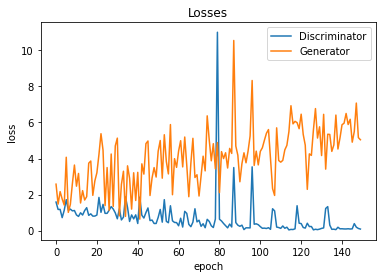

In [29]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

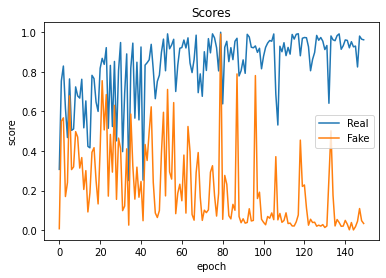

In [30]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [31]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

150